In [1]:
from app.face_reconstruction import FaceReconstructor

reconstructor = FaceReconstructor(root_dir="..", models_dir="../models", device="cuda")

/home/werserk/PycharmProjects/biometrics-hack/.venv/lib/python3.12/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/werserk/PycharmProjects/biometrics-hack/.venv/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. De

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/antelopev2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/antelopev2/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/antelopev2/arcface.onnx recognition ['None', 3, 112, 112] 127.5 127.5
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/antelopev2/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/antelopev2/scrfd_10g_bnkps.onnx detection [1, 3, '?', '?'] 127.5 128.0
set det-size: (640, 640)


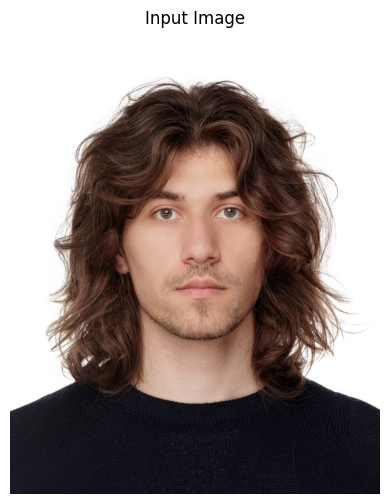

In [2]:
from matplotlib import pyplot as plt
import cv2

test_image_path = "../assets/examples/max.jpg"
test_image = cv2.imread(test_image_path)

plt.figure(figsize=(6, 6))
plt.imshow(test_image[:, :, ::-1])
plt.axis("off")
plt.title("Input Image")
plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]

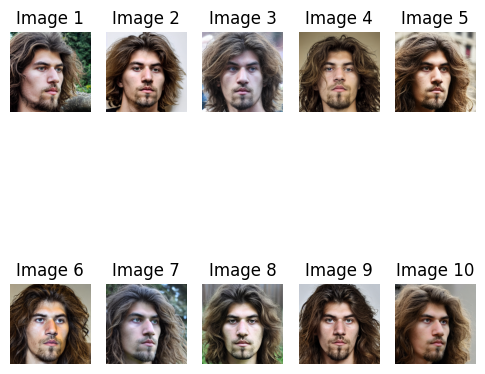

In [17]:
test_embedding = reconstructor.image2embedding(test_image)
images = reconstructor.generate_images_by_embedding(test_embedding, num_images=10)

plt.subplots(2, 5, figsize=(6, 6))
for i in range(len(images)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis("off")
    plt.title(f"Image {i + 1}")
plt.show()

In [28]:
from app.metric import Similarity

from insightface.app import FaceAnalysis

model = FaceAnalysis(
    name="buffalo_l", root="..", providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
)
model.prepare(ctx_id=0, det_size=(640, 640))

metric = Similarity(model=model)
metric.get_embedding(images[1])

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


array([-6.91784173e-02, -1.00808740e-01, -4.50022332e-02,  2.95529123e-02,
       -2.00910904e-02,  2.17205212e-02,  8.36296827e-02,  3.25201787e-02,
        2.76506748e-02, -1.35935815e-02,  3.10991816e-02, -1.62585638e-02,
       -5.31479567e-02, -3.17235440e-02, -6.00315221e-02,  6.73049465e-02,
        1.77773125e-02, -1.32155931e-02, -3.86471935e-02, -5.88704236e-02,
        4.82995026e-02,  5.39459288e-02,  1.57076232e-02,  1.77925192e-02,
        1.23730507e-02,  8.07533320e-03, -4.76462655e-02, -9.73020941e-02,
        2.09446345e-02, -5.64677157e-02, -7.22715631e-02, -4.54256646e-02,
       -3.07900924e-02, -2.20768707e-04,  7.46738724e-03,  4.33221497e-02,
       -9.09983441e-02,  6.65860474e-02, -3.30622937e-03, -3.07398643e-02,
        7.31955096e-02,  9.33528468e-02,  4.23108377e-02, -9.43989009e-02,
       -5.17506897e-02, -9.47109386e-02, -9.55232070e-04,  1.21663429e-03,
       -3.11501045e-02,  8.22757781e-02,  2.24521030e-02, -4.20874130e-06,
       -7.74252042e-03,  

In [29]:
mean_metric_value = 0
count = 0
for i in range(len(images)):
    try:
        metric_value = metric(images[i], test_image)
        mean_metric_value += metric_value
        count += 1
        
        print(f"Compare image {i + 1} and test image: {metric_value}")
    except Exception as e:
        print(e)
print(mean_metric_value / count)

Compare image 1 and test image: 0.7073321342468262
Compare image 2 and test image: 0.7353686094284058
Compare image 3 and test image: 0.7522864937782288
Compare image 4 and test image: 0.7220557332038879
Compare image 5 and test image: 0.7705135345458984
list index out of range
Compare image 7 and test image: 0.7369222640991211
Compare image 8 and test image: 0.7712750434875488
Compare image 9 and test image: 0.7250856161117554
Compare image 10 and test image: 0.7376368641853333
0.73983073


In [30]:
# compare true faces
max1 = cv2.imread("../assets/examples/max.jpg")
max2 = cv2.imread("../assets/examples/max2.jpg")
max3 = cv2.imread("../assets/examples/max3.jpg")
max4 = cv2.imread("../assets/examples/max4.jpg")

print(f"Compare max1 and max2: {metric(max1, max2)}")
print(f"Compare max1 and max3: {metric(max1, max3)}")
print(f"Compare max1 and max4: {metric(max1, max4)}")

print(f"Compare max2 and max3: {metric(max2, max3)}")
print(f"Compare max2 and max4: {metric(max2, max4)}")

print(f"Compare max3 and max4: {metric(max3, max4)}")

Compare max1 and max2: 0.5490817427635193
Compare max1 and max3: 0.5357904434204102
Compare max1 and max4: 0.8120352625846863
Compare max2 and max3: 0.6212565302848816
Compare max2 and max4: 0.6478919386863708
Compare max3 and max4: 0.5168261528015137
